<a href="https://colab.research.google.com/github/OIZHENHAU/HackerSquad/blob/main/Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import pandas as pd
import re
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold
from numpy import arange
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


class LassoRegressionCVModel:
    def __init__(self, start_value, end_value, step_size, n_splits, n_repeats):
        self.start_value = start_value
        self.end_value = end_value
        self.step_size = step_size
        self.n_splits = n_splits
        self.n_repeats = n_repeats
        self.cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats)
        self.model = LassoCV(alphas=arange(start_value, end_value, step_size), cv=self.cv)

    def fit(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        y_pred = self.model.predict(X_test)
        return y_pred

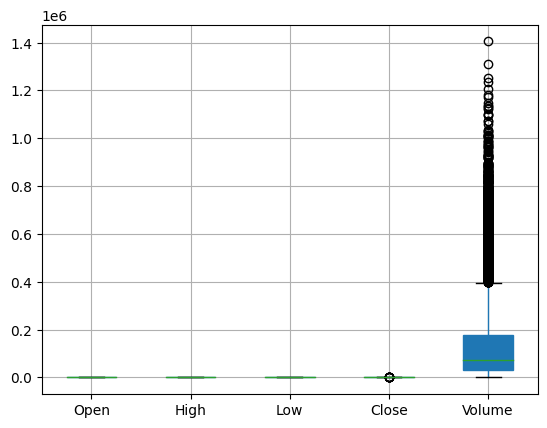

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.701e+03, tolerance: 2.279e+03
  model = cd_fast.enet_coordinate_descent(


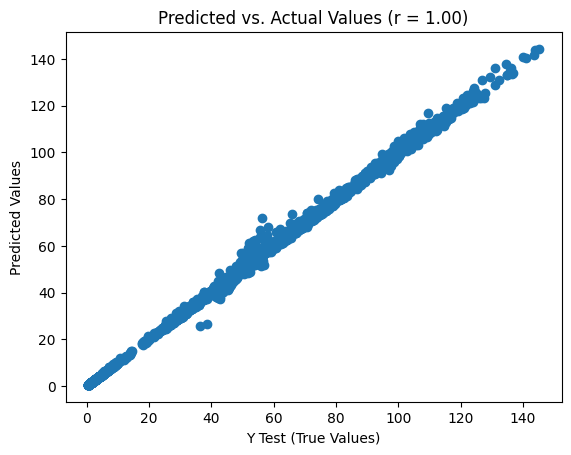

      Metric  Value
0        MAE  0.471
1        MSE  1.078
2       RMSE  1.038
3  R-Squared  0.999



In [15]:
import sys
import os

py_file_location = "/content/drive/MyDrive/Colab_Notebooks"
sys.path.append(os.path.abspath(py_file_location))

import numpy as np
import pandas as pd
import io
import requests
import torch
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sbn
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, shapiro
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
# from LassoRegression import LassoRegressionCVModel

oilGas_csv = '/content/drive/MyDrive/Colab_Notebooks/oil_and_gas_data.csv'

oilGas_df = pd.read_csv(oilGas_csv)


# ################################# Impute DatasSet ################################################
def impute_dataset(df: pd.DataFrame):
    cols = df.columns

    for column in df.select_dtypes(include=['number']).columns:
        mean_value = df[column].mean()

        df[column].fillna(mean_value, inplace=True)


impute_dataset(oilGas_df)


# ################################ REMOVE OUTLIERS #################################################

def check_outlier(df: pd.DataFrame):
    curr_df = df
    cols = curr_df.columns

    curr_df.boxplot(patch_artist=True)
    plt.show()


check_outlier(oilGas_df)


def remove_outliers(df: pd.DataFrame):
    curr_df = df
    cols = curr_df.columns

    for i in range(len(cols)):
        col = cols[i]

        if col == 'Close':
            continue

        if curr_df[col].dtypes == 'object':
            continue

        Q1 = curr_df[col].quantile(0.25)
        Q3 = curr_df[col].quantile(0.75)

        IQR = Q3 - Q1

        Lower_Range = Q1 - (1.5 * IQR)
        Upper_Range = Q3 + (1.5 * IQR)

        # count = ((curr_df[col] < Lower_Range) | (curr_df[col] > Upper_Range)).sum()
        curr_df = curr_df[~((curr_df[col] < Lower_Range) | (curr_df[col] > Upper_Range))]

    return curr_df


oilGas_df = remove_outliers(oilGas_df)
# print(oilGas_df)

# ##################################### LABEL ENCODING ########################################################
label_encoder = LabelEncoder()

data_column_category = oilGas_df.select_dtypes(exclude=[np.number]).columns

for category_column in data_column_category:
    oilGas_df[category_column] = label_encoder.fit_transform(oilGas_df[category_column])


# #################################### PROCESSING DATA #########################################################
def processing_and_scale_data(df: pd.DataFrame):
    X = df[['Symbol', 'Open', 'High', 'Low', 'Volume']]
    y = df['Close']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    minmax_scaler = preprocessing.MinMaxScaler()
    X_train = minmax_scaler.fit_transform(X_train)
    X_test = minmax_scaler.transform(X_test)

    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = processing_and_scale_data(oilGas_df)
lassoCVModel = LassoRegressionCVModel(0.01, 1, 0.01, 10, 3)

lassoCVModel.fit(X_train, y_train)

prediction = lassoCVModel.predict(X_test)

plt.scatter(y_test, prediction)
plt.xlabel('Y Test (True Values)')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values (r = {0:0.2f})'.format(pearsonr(y_test, prediction)[0], 2))
plt.show()

# ##################################### PERFORM METRICS ######################################################

metrics_df = pd.DataFrame({'Metric':
                               ['MAE',
                                'MSE',
                                'RMSE',
                                'R-Squared'], 'Value':
                               [metrics.mean_absolute_error(y_test, prediction),
                                metrics.mean_squared_error(y_test, prediction),
                                np.sqrt(metrics.mean_squared_error(y_test, prediction)),
                                metrics.explained_variance_score(y_test, prediction)]}).round(3)
print(metrics_df)
print()

